Minecraft Research Server - DSCI 100
Giles Lo

In [132]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)

library(GGally)
library(ISLR)

options(repr.matrix.max.rows = 6)

set.seed(2025) # DO NOT REMOVE

Introduction

Question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Strategy Overview

Reading File

In [133]:
# Run this cell to read files
players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")

players <- players |>
    mutate(subscribe = as_factor(subscribe)) |>
    filter(Age != "NA", played_hours < 100)
players
sessions

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


Exploring the Data

First, lets remove all the rows containing "NA" from the data.

In [134]:
sessions_clean <- sessions |>
    select(start_time, end_time) |>
    separate(col = start_time, into = c("start_date", "start_time"), sep = " ") |>
    separate(col = end_time, into = c("end_date", "end_time"), sep = " ") |>
    filter(!is.na(start_date), !is.na(end_date), !is.na(start_time), !is.na(end_time))
sessions_clean

start_date,start_time,end_date,end_time
<chr>,<chr>,<chr>,<chr>
30/06/2024,18:12,30/06/2024,18:24
17/06/2024,23:33,17/06/2024,23:46
25/07/2024,17:34,25/07/2024,17:57
⋮,⋮,⋮,⋮
28/07/2024,15:36,28/07/2024,15:57
25/07/2024,06:15,25/07/2024,06:22
20/05/2024,02:26,20/05/2024,02:45


Let's draw a single sample of size 40 from the population and visualize it:

In [ ]:
one_sample <- can_seniors |> 
    rep_sample_n(40) |> 
    ungroup() |> # ungroup the data frame 
    select(age) # drop the replicate column 
one_sample

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 7)
# run this cell 
one_sample_dist <- ggplot(one_sample, aes(age)) + 
    geom_histogram(binwidth = 1) +
    xlab("Age (years)") +
    ggtitle("Distribution of one sample") +
    theme(text = element_text(size = 20))
one_sample_dist

In [ ]:
one_sample_estimates <- one_sample |>
    summarize(mean = mean(age))
one_sample_estimates

Bootstraping Data

In [135]:
boot_sessions_100 <- sessions_clean |>
    rep_sample_n(size = 100, replace = TRUE, reps = 10)
head(boot_sessions)

replicate,start_date,start_time,end_date,end_time
<int>,<chr>,<chr>,<chr>,<chr>
1,17/07/2024,01:10,17/07/2024,04:30
1,24/06/2024,18:12,24/06/2024,18:18
1,30/06/2024,03:18,30/06/2024,04:15
1,25/06/2024,03:38,25/06/2024,03:45
1,14/06/2024,04:28,14/06/2024,05:32
1,04/05/2024,20:41,04/05/2024,21:51


In [136]:
sessions_month_100 <- boot_sessions_100 |>
    mutate(start_date = as.Date(start_date, format = "%d/%m/%Y"), end_date = as.Date(end_date, format = "%d/%m/%Y")) |>
    mutate(date = map2(start_date, end_date, ~seq(.x, .y, by = "day"))) |>
    unnest(date) |>
    mutate(month = format(date, "%m")) |>
    count(month) |>
    rename(count = n)
sessions_month_100

replicate,month,count
<int>,<chr>,<int>
1,04,7
1,05,15
1,06,38
⋮,⋮,⋮
10,07,21
10,08,23
10,09,7


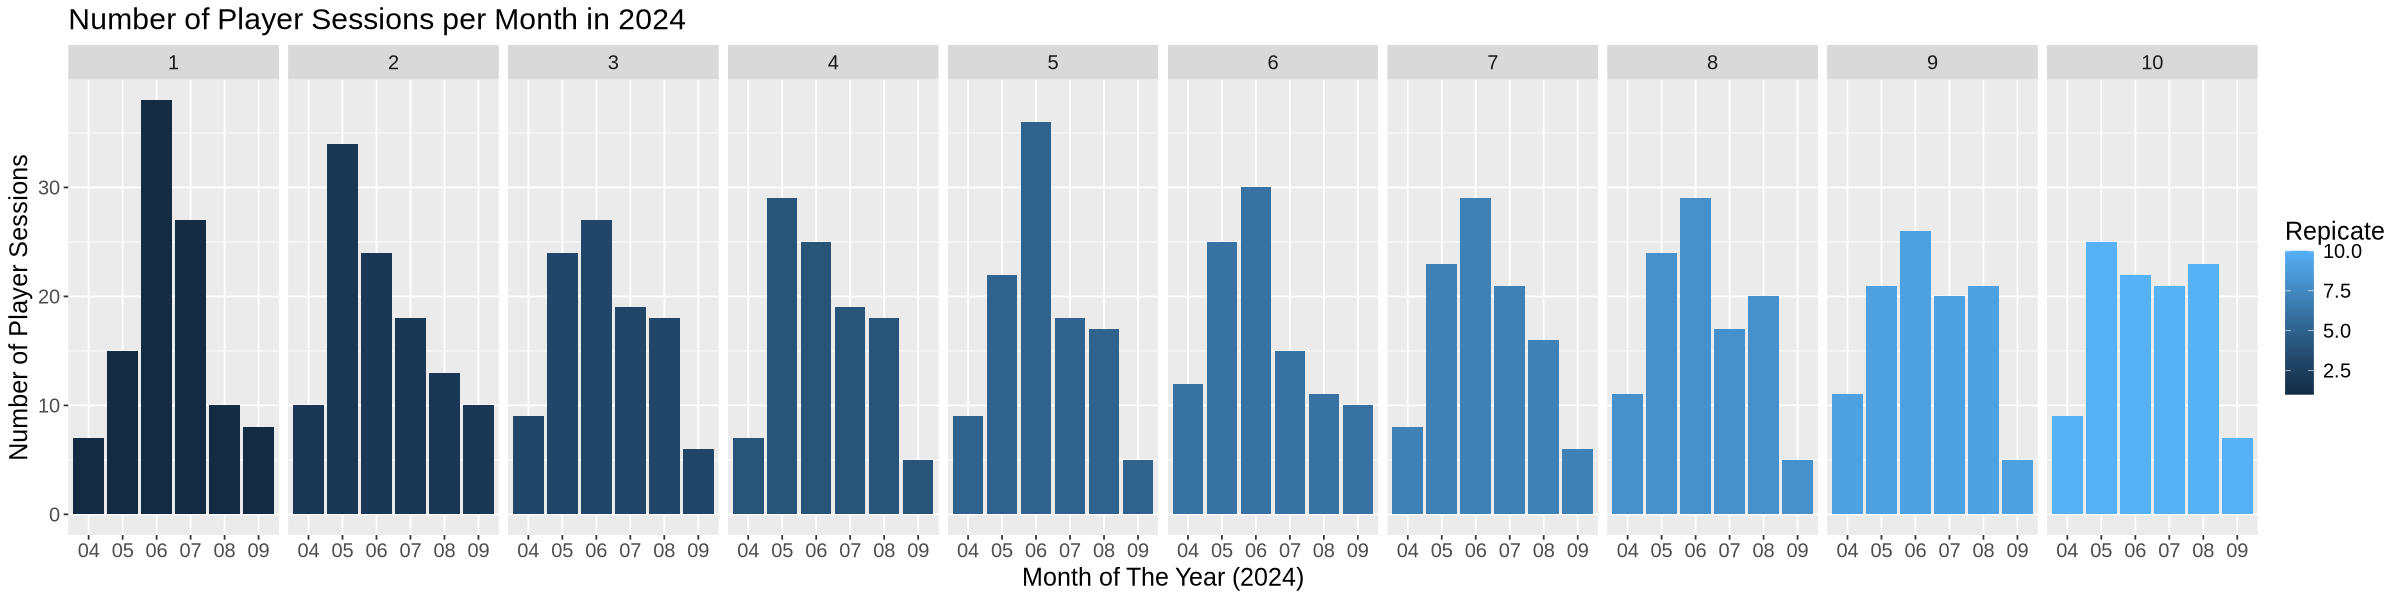

In [137]:
options(repr.plot.width = 20, repr.plot.height = 5)

sessions_plot_100 <- sessions_month_100 |>
    ggplot(aes(x = month, y = count, fill = replicate)) + 
    geom_col() +
    facet_grid(cols = vars(replicate)) + 
    labs(x = "Month of The Year (2024)",
         y = "Number of Player Sessions", 
         title = "Number of Player Sessions per Month in 2024",
         fill = "Repicate") +
    theme(text = element_text(size = 15))

sessions_plot_100

Analysis of Plot

We see that...

Now let's see what the greatest average players for the months are for many reps

In [138]:
boot_sessions <- sessions_clean |>
    rep_sample_n(size = 100, replace = TRUE, reps = 300)

sessions_month <- boot_sessions |>
    mutate(start_date = as.Date(start_date, format = "%d/%m/%Y"), end_date = as.Date(end_date, format = "%d/%m/%Y")) |>
    mutate(date = map2(start_date, end_date, ~seq(.x, .y, by = "day"))) |>
    unnest(date) |>
    mutate(month = format(date, "%m")) |>
    count(month) |>
    rename(count = n)
sessions_month

sessions_month_average <- sessions_month |>
    group_by(month) |>
    summarize(count = round(mean(count)))
sessions_month_average

replicate,month,count
<int>,<chr>,<int>
1,04,8
1,05,18
1,06,39
⋮,⋮,⋮
300,07,23
300,08,11
300,09,2


month,count
<chr>,<dbl>
04,10
05,24
06,30
07,20
08,16
09,6


We now have the

In [139]:
sessions_month_max <- sessions_month_average|>
    arrange(count) |>
    slice(1) |>
    pull()
sessions_month_max

[1] 6

We see that on average, there are a greater total number of player sessions in June.

Lets now visualize the av

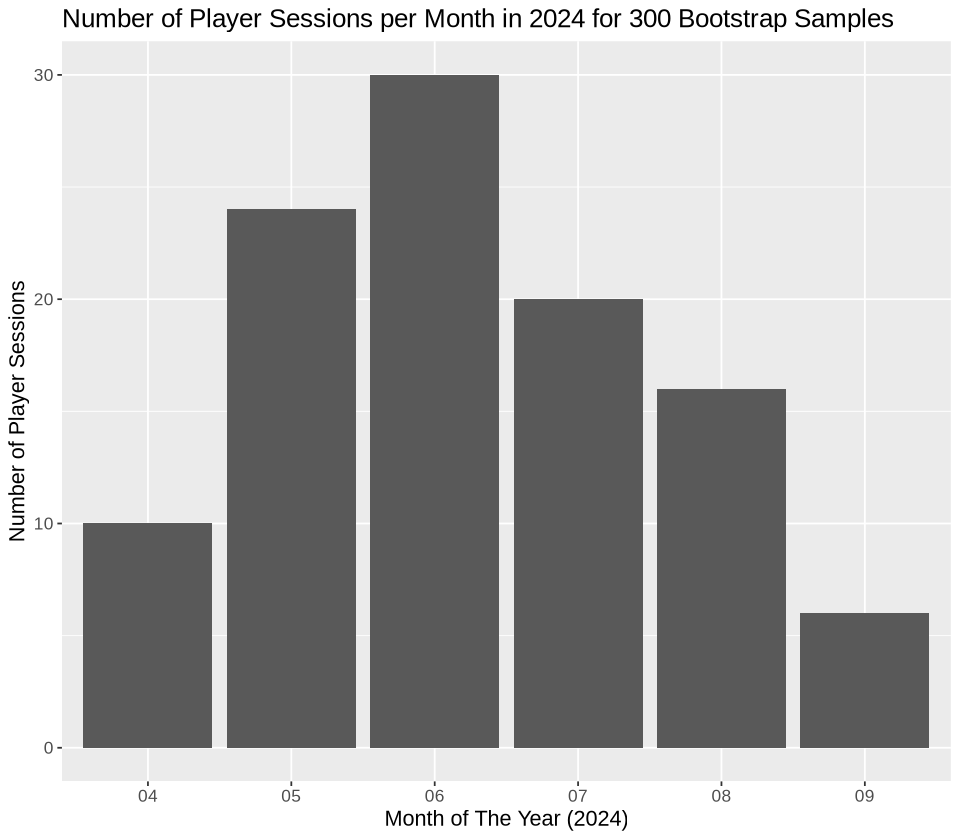

In [140]:
options(repr.plot.width = 8, repr.plot.height = 7)

sessions_plot <- sessions_month_average |>
    ggplot(aes(x = month, y = count)) + 
    geom_col() + 
    labs(x = "Month of The Year (2024)",
         y = "Number of Player Sessions", 
         title = "Number of Player Sessions per Month in 2024 for 300 Bootstrap Samples",
         fill = "Repicate") +
    theme(text = element_text(size = 13))
sessions_plot

We also see that May has a relative large number of player sessions, as such we should increase number of licenses on hand to sufficiently accommodate all parallel players with high probability.

In [141]:
sessions_time <- boot_sessions |>
    mutate(start_datetime = as.POSIXct(paste(start_date, start_time), format = "%d/%m/%Y %H:%M"), 
           end_datetime = as.POSIXct(paste(end_date, end_time), format = "%d/%m/%Y %H:%M")) |>
    mutate(datetime = map2(start_datetime, end_datetime, ~seq(.x, .y, by = "hour"))) |>
    unnest(datetime) |>
    mutate(time_6hr = as.POSIXct(cut(datetime, breaks = "6 hours"))) |>
    mutate(month = format(time_6hr, "%m"), 
           time = format(time_6hr, "%H:%M")) |>
    count(month, time, name = "count")
sessions_time

sessions_time_average <- sessions_time |>
    group_by(month, time) |>
    summarize(count = round(mean(count)))
sessions_time_average

replicate,month,time,count
<int>,<chr>,<chr>,<int>
1,04,03:00,1
1,04,15:00,2
1,04,21:00,6
⋮,⋮,⋮,⋮
300,07,00:00,37
300,08,00:00,17
300,09,00:00,2


`summarise()` has grouped output by 'month'. You can override using the
`.groups` argument.


month,time,count
<chr>,<chr>,<dbl>
04,00:00,11
04,01:00,5
04,02:00,5
⋮,⋮,⋮
09,21:00,4
09,22:00,4
09,23:00,4


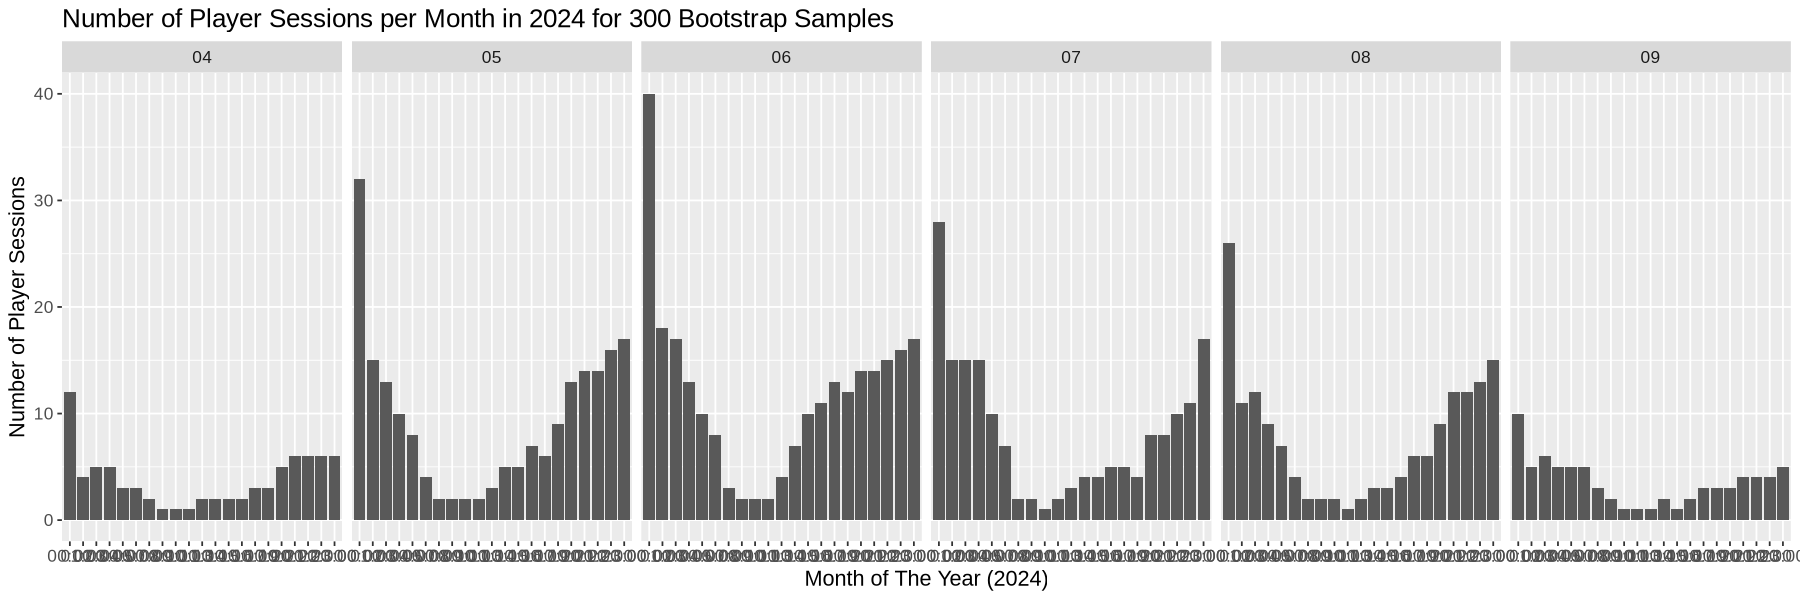

In [115]:
options(repr.plot.width = 15, repr.plot.height = 5)

sessions_time_plot <- sessions_time_average |>
    ggplot(aes(x = time, y = count)) + 
    geom_col() + 
    facet_grid(cols = vars(month)) +
    labs(x = "Month of The Year (2024)",
         y = "Number of Player Sessions", 
         title = "Number of Player Sessions per Month in 2024 for 300 Bootstrap Samples",
         fill = "Repicate") +
    theme(text = element_text(size = 13))
sessions_time_plot

In [151]:
sessions_time_max <- sessions_time |>
    group_by(time) |>
    summarize(count = round(mean(count))) |>
    arrange(desc(count)) |>
    slice(1) |>
    pull(time)
sessions_time_max

[1] "00:00"

We observe that 00:00-01:00 or 12:00-1:00 AM is the most popular times.